In [18]:
import torch
import pandas as pd
from torch_geometric.data import DataLoader, Batch, Data
from embedding import GNN
from downstream import MLP
from conexplainer import ContExplainer, MLPExplainer
from loader import MoleculeDataset
from splitters import scaffold_split
from dig.xgraph.evaluation import XCollector

from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display

device = torch.device("cuda:3" if torch.cuda.is_available() else torch.device("cpu"))

def get_task(idx):
    def transform(data):
        return Data(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr, y=data.y[idx:idx+1].long())
    return transform

def get_dataset(name, task=0):
    task_transform = get_task(task)
    dataset = MoleculeDataset("dataset/%s"%name, dataset=name, transform=task_transform)
    smiles_list = pd.read_csv('dataset/%s/processed/smiles.csv'%name, header=None)[0].tolist()
    return dataset, smiles_list

In [2]:
embed_model = GNN(num_layer = 5, emb_dim = 600, JK = 'last', drop_ratio = 0, gnn_type = 'gin')
embed_model.load_state_dict(torch.load('ckpts_model/chem_pretrained_contextpred.pth', map_location='cpu'))
enc_explainer = ContExplainer(embed_model, embed_dim=600, device=device, explain_graph=True, 
                              grad_scale=0.2, coff_size=0.05, coff_ent=0.002, loss_type='JSE')

state_dict = torch.load('ckpts_explainer/explain_mol_twostage.pt')
enc_explainer.explainer.load_state_dict(state_dict)

<All keys matched successfully>

In [67]:
task_name = 'hiv'
dataset, smiles_list = get_dataset(task_name)
mlp_model = MLP(num_layer = 2, emb_dim =600, hidden_dim = 600)
mlp_model.load_state_dict(torch.load('ckpts_model/downstream_%s_contextpred.pth'%task_name, map_location='cpu'))
mlp_explainer = MLPExplainer(mlp_model, device)

In [68]:
def visual_molecule(mid, cond=None):
    smiles = smiles_list[mid]
    mol = Chem.MolFromSmiles(smiles)
    
    data = Batch.from_data_list([dataset[mid]])
    top_k = max(1, int(data.edge_index.shape[1]*0.1))
    walks, masks, related_preds = \
        enc_explainer(data.to(device), mlp_explainer, top_k=top_k, mask_mode='split', cond_vec=cond)
    print(related_preds[0]['origin']-related_preds[0]['maskout'])
    highlights = torch.topk(masks[data.edge_index[0]>data.edge_index[1]], top_k)
    
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(280, 280)
    drawer.SetFontSize(1)

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=highlights.indices.tolist())
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    
    return svg

In [97]:
def display_id(data_id):
    embed_model.eval()
    data = Batch.from_data_list([dataset[data_id]])
    topkd = embed_model(data.to(device)).topk(40)[1]

    for did in topkd[0]:
        cond = torch.zeros([1, 600])
        cond[0, did] = 20
        svg = visual_molecule(data_id, cond=cond)
        print(did)
        display(SVG(svg))
        
def spa_id(mid, cond=None):
    smiles = smiles_list[mid]
    mol = Chem.MolFromSmiles(smiles)
    
    data = Batch.from_data_list([dataset[mid]])
    top_k = max(1, int(data.edge_index.shape[1]*0.1))
    walks, masks, related_preds = \
        enc_explainer(data.to(device), mlp_explainer, top_k=top_k, mask_mode='split', cond_vec=cond)
    return related_preds[0]['origin']-related_preds[0]['maskout']

0.6444323062896729


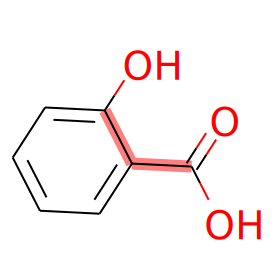

In [73]:
svg = visual_molecule(6)
SVG(svg)

0.014076590538024902


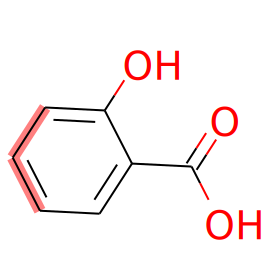

In [21]:
cond = torch.zeros([1, 600])
cond[0, 78] = 20
svg = visual_molecule(6, cond=cond)
SVG(svg)

3.0994415283203125e-06


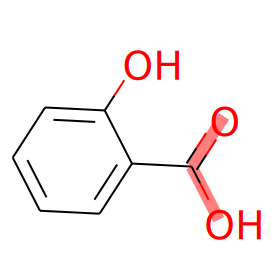

In [23]:
cond = torch.zeros([1, 600])
cond[0, 312] = 20
svg = visual_molecule(6, cond=cond)
SVG(svg)

0.2617366909980774


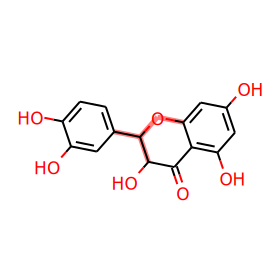

In [72]:
svg = visual_molecule(134)
SVG(svg)

0.026331841945648193


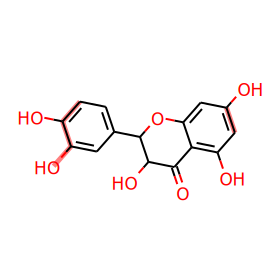

In [75]:
cond = torch.zeros([1, 600])
cond[0, 334] = 20
svg = visual_molecule(134, cond=cond)
SVG(svg)

0.2890031933784485


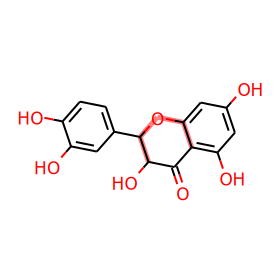

In [76]:
cond = torch.zeros([1, 600])
cond[0, 424] = 20
svg = visual_molecule(134, cond=cond)
SVG(svg)

0.9820458712056279


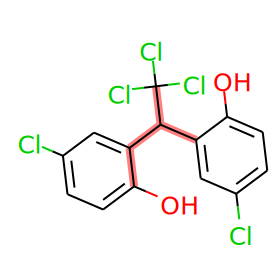

In [78]:
svg = visual_molecule(203)
SVG(svg)

0.0


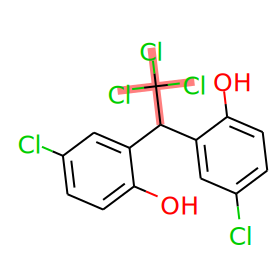

In [80]:
cond = torch.zeros([1, 600])
cond[0, 312] = 20
svg = visual_molecule(203, cond=cond)
SVG(svg)

0.989448444917798


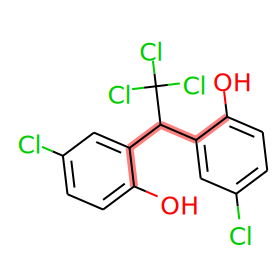

In [81]:
cond = torch.zeros([1, 600])
cond[0, 326] = 20
svg = visual_molecule(203, cond=cond)
SVG(svg)

0.5763764679431915


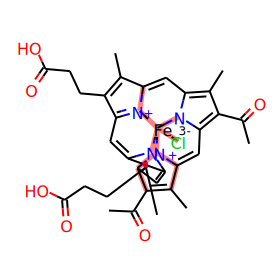

In [100]:
svg = visual_molecule(818)
SVG(svg)

0.4154670089483261


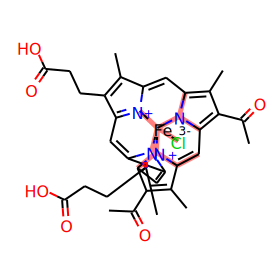

In [106]:
cond = torch.zeros([1, 600])
cond[0, 434] = 20
svg = visual_molecule(818, cond=cond)
SVG(svg)

0.4357481151819229


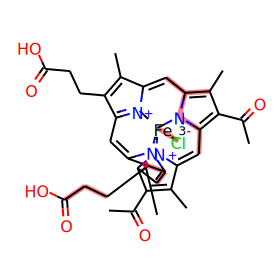

In [107]:
cond = torch.zeros([1, 600])
cond[0, 78] = 20
svg = visual_molecule(818, cond=cond)
SVG(svg)